# Main setting

In [ ]:
import numpy as np
from time import time
from sys import stdout
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import *

np.random.seed(521)

In [ ]:
def nlssubprob(V, W, Hinit, tol, maxiter, isadmm=False):
    """
    H, grad: output solution and gradient
    iter: #iterations used
    V, W: constant matrices
    Hinit: initial solution
    tol: stopping tolerance
    maxiter: limit of iterations
    """
    num_sub_iter = 0
    sub_obj_values = []
    sub_kkt_values = []
    H = np.copy(Hinit)
    WtV = np.dot(W.T, V)
    WtW = np.dot(W.T, W)

    alpha = 1
    beta = 0.1
    for iter in range(1, maxiter):
        num_sub_iter += 1
        grad = np.dot(WtW, H) - WtV
        projgrad = np.linalg.norm(grad[np.logical_or(grad < 0, H > 0)])
        sub_obj_values.append(objective_function(V, W, H))
        if isadmm:
            sub_kkt_values.append(np.linalg.norm(W * gradient_W(W, H, V)))
        if projgrad < tol:
            break

        # search step size
        for inner_iter in range(1, 20):
            Hn = H - alpha * grad
            Hn = project(Hn)  # projected H
            d = Hn - H
            gradd = np.sum(grad * d)
            dQd = np.sum(np.dot(WtW, d) * d)
            suff_decr = 0.99 * gradd + 0.5 * dQd < 0
            if inner_iter == 1:
                decr_alpha = not suff_decr
                Hp = H
            if decr_alpha:
                if suff_decr:
                    H = Hn
                    break
                else:
                    alpha = alpha * beta
            else:
                if not suff_decr or np.all(Hp == Hn):
                    H = Hp
                    break
                else:
                    alpha = alpha / beta
                    Hp = Hn

        if iter == maxiter:
            print('Max iter in nlssubprob')
    if isadmm:
        return (H, grad, iter, num_sub_iter, sub_obj_values, sub_kkt_values)
    return (H, grad, iter, num_sub_iter, sub_obj_values)


In [ ]:
m = 100
n = 70
r = 30
V = np.abs(np.random.normal(size=(n, m))) * 10
W_init = np.abs(np.random.normal(size=(n, r))) * 10  # initial value of W
H_init = np.abs(np.random.normal(size=(r, m))) * 10  # initial value of H
# H_init, _, _ = nlssubprob(V, W_init, H_init, 1e-5, 10000)

In [ ]:
def objective_function(V, W, H):
    frobenius = 0
    T = V - (W @ H)
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            frobenius += T[i][j]**2
    return 0.5 * frobenius

In [ ]:
def project(x):
    return np.maximum(x, 0)

def gradient_W(W, H, V):
    return (W @ H - V) @ H.T

def gradient_H(W, H, V):
    return W.T @ (W @ H - V)

# projnorm = np.linalg.norm(np.concatenate((gradW[np.logical_or(gradW < 0, W > 0)], gradH[np.logical_or(gradH < 0, H > 0)])))
# gradW = np.dot(W, np.dot(H, H.T)) - np.dot(V, H.T)
# gradH = np.dot(np.dot(W.T, W), H) - np.dot(W.T, V)
def projected_gradient_norm(W, H, V):
    gradW = gradient_W(W, H, V)
    gradH = gradient_H(W, H, V)
    return np.linalg.norm(np.concatenate((gradW[np.logical_or(gradW < 0, W > 0)], gradH[np.logical_or(gradH < 0, H > 0)])))

# Multiplicative Update Method

In [ ]:
plot_obj_mul = []
plot_kkt_mul = []
W = np.copy(W_init)
H = np.copy(H_init)
for _ in range(20000):
    W_prime = W * ((V @ H.T) / (W @ H @ H.T))
    H_prime = H * ((W_prime.T @ V) / (W_prime.T @ W_prime @ H))
    plot_obj_mul.append(objective_function(V, W_prime, H_prime))
    plot_kkt_mul.append(np.linalg.norm(W * gradient_W(W, H, V)))
    # print(objective_function(V, W_prime, H_prime))
    if np.linalg.norm(W - W_prime) <= 1e-8 * n * r and np.linalg.norm(H - H_prime) <= 1e-8 * m * r:
        break
    W = W_prime
    H = H_prime

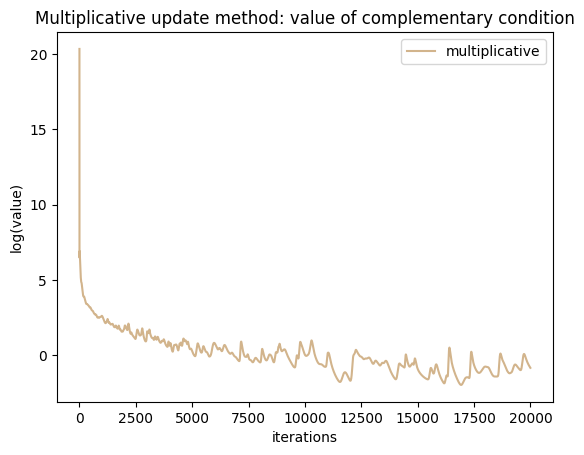

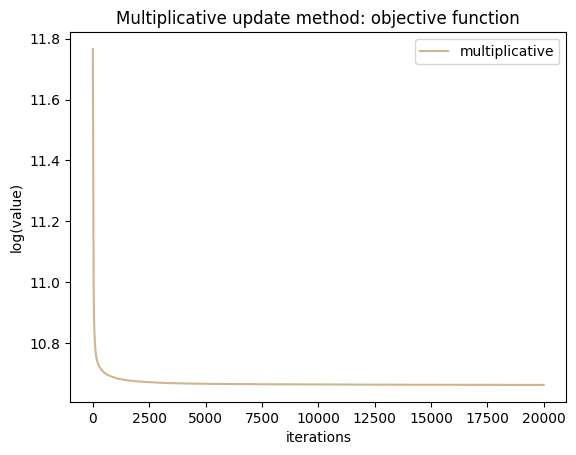

In [ ]:
plot_kkt_mul = np.array(plot_kkt_mul)
plt.plot(range(len(plot_kkt_mul)), np.log(plot_kkt_mul), color='tan', label='multiplicative')
plt.title("Multiplicative update method: value of complementary condition")
plt.xlabel("iterations")
plt.ylabel("log(value)")
plt.legend()
plt.show()
plot_obj_mul = np.array(plot_obj_mul)
plt.plot(range(len(plot_obj_mul)), np.log(plot_obj_mul), color='tan', label='multiplicative')
plt.title("Multiplicative update method: objective function")
plt.xlabel("iterations")
plt.ylabel("log(value)")
plt.legend()
plt.show()

In [ ]:
print(np.linalg.norm(V - W @ H))
W_rand = np.random.uniform(size=(n, r))  # initial value of W
H_rand = np.random.uniform(size=(r, m))  # initial value of H
print(np.linalg.norm(V - W_rand @ H_rand))

292.5128253465934
527.0517865308401


## Check the KKT condition for Multiplicative Update

In [ ]:
print(np.linalg.norm(W * gradient_W(W, H, V)))  # This should be close to 0 if the KKT is satisfied
print(objective_function(V, W, H))
print(W * gradient_W(W, H, V))

962.5204100769233
62609.428685276565
[[ 0.00000000e+00  9.00573539e-01  2.20624130e-02 ...  0.00000000e+00
   2.67992734e+01  1.48766694e+01]
 [ 9.95555108e-01  3.88485845e-03  0.00000000e+00 ... -2.58940827e+01
   0.00000000e+00 -1.03372666e+01]
 [ 0.00000000e+00  0.00000000e+00 -9.97493114e+00 ...  1.13653058e+01
   5.22815587e+01 -1.54795564e+00]
 ...
 [-6.30951091e+00  0.00000000e+00 -2.74400722e+01 ...  3.30491037e+00
   1.03835567e+01 -4.49956822e+00]
 [ 1.52329920e+01 -3.08768635e+00  4.40131724e+00 ...  0.00000000e+00
  -1.31074105e+01 -3.92586204e+01]
 [-1.22592658e+01  1.01452954e-01  2.63978550e+00 ...  1.69839830e-01
  -2.94599290e+01  0.00000000e+00]]


# Directly Apply Projected Gradient Method

## main function

In [ ]:
beta = 0.5
sigma = 0.1

def armijoly_update(alpha, old_W, old_H):
    g_W = gradient_W(old_W, old_H, V)
    g_H = gradient_H(old_W, old_H, V)
    def is_suffly_decrease(alpha, new_W, new_H, old_W, old_H):
        return objective_function(V, new_W, new_H) < objective_function(V, old_W, old_H) + sigma * (np.sum(g_W * (new_W - old_W)) + np.sum(g_H * (new_H - old_H)))
    new_W = project(old_W - alpha * g_W)
    new_H = project(old_H - alpha * g_H)
    if is_suffly_decrease(alpha, new_W, new_H, old_W, old_H):
        while True:  # If armijo is satisfied, increase the alpha until it is not satisfied
            # print("increased! now alpha:", alpha)
            alpha_prime = alpha / beta
            new_W_prime = project(old_W - alpha_prime * g_W)
            new_H_prime = project(old_H - alpha_prime * g_H)
            # print(objective_function(V, new_W_prime, new_H_prime))
            # print(objective_function(V, old_W, old_H) + sigma * (np.sum(g_W * (new_W_prime - old_W)) + np.sum(g_H * (new_H_prime - old_H))))
            # input()
            if not is_suffly_decrease(alpha_prime, new_W_prime, new_H_prime, old_W, old_H) or (np.array_equal(new_W_prime, new_W) and np.array_equal(new_H_prime, new_H)):
                break
            alpha = alpha_prime  # increase the alpha
            new_W = new_W_prime
            new_H = new_H_prime
    else:
        while True:  # If armijo is NOT satisfied, decrease the alpha until it is satisfied
            # print("decreased! now alpha:", alpha)
            alpha_prime = alpha * beta
            new_W_prime = project(old_W - alpha_prime * g_W)
            new_H_prime = project(old_H - alpha_prime * g_H)
            # print(objective_function(V, new_W_prime, new_H_prime))
            # print(objective_function(V, old_W, old_H) + sigma * (np.sum(g_W * (new_W_prime - old_W)) + np.sum(g_H * (new_H_prime - old_H))))
            # input()
            if is_suffly_decrease(alpha_prime, new_W_prime, new_H_prime, old_W, old_H) or (np.array_equal(new_W_prime, new_W) and np.array_equal(new_H_prime, new_H)):
                new_W = new_W_prime
                new_H = new_H_prime
                break
            alpha = alpha_prime  # decrease the alpha
            new_W = new_W_prime
            new_H = new_H_prime
    return alpha, new_W, new_H

In [ ]:
plot_obj_dir = []
plot_kkt_dir = []
alpha = 2
W = np.copy(W_init)
H = np.copy(H_init)
H, _, _, _, _ = (nlssubprob(V, W, H, 1e-5, 10000))
i = 0
init_grad_norm = np.linalg.norm(np.concatenate((gradient_H(W, H, V).reshape(-1), gradient_W(W, H, V).reshape(-1))))
for _ in range(20000):
    alpha, W_prime, H_prime = armijoly_update(alpha, W, H)
    if projected_gradient_norm(W, H, V) < 1e-5 * init_grad_norm:
        break
    plot_obj_dir.append(objective_function(V, W, H))
    plot_kkt_dir.append(np.linalg.norm(W * gradient_W(W, H, V)))
    W = W_prime
    H = H_prime

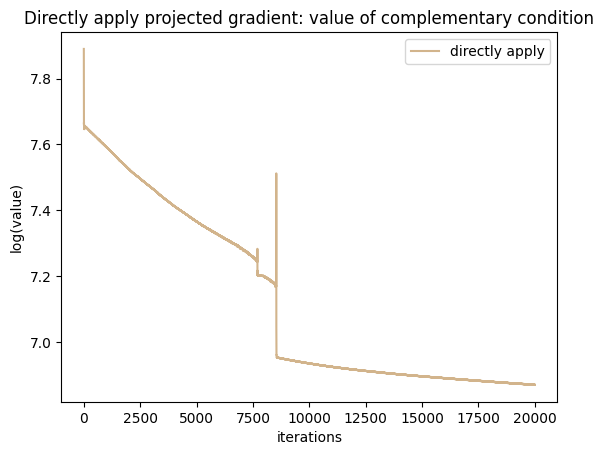

In [ ]:
plot_kkt_dir = np.array(plot_kkt_dir)
plt.plot(range(len(plot_kkt_dir)), np.log(plot_kkt_dir), color='tan', label='directly apply')
plt.title("Directly apply projected gradient: value of complementary condition")
plt.xlabel("iterations")
plt.ylabel("log(value)")
plt.legend()
plt.show()

In [ ]:
print(np.linalg.norm(V - W @ H))
W_rand = np.random.uniform(size=(n, r))  # initial value of W
H_rand = np.random.uniform(size=(r, m))  # initial value of H
print(np.linalg.norm(V - W_rand @ H_rand))

353.8627662958526
526.4842813712964


## Check the KKT condition for Directly Apply
<font color='orange'>很明顯結果比 Multiplicative Update還不 KKT</font>

In [ ]:
print(np.linalg.norm(W * gradient_W(W, H, V)))  # This should be close to 0 if the KKT is satisfied
print(objective_function(V, W, H))
print(W * gradient_W(W, H, V))

962.5204100769233
62609.428685276565
[[ 0.00000000e+00  9.00573539e-01  2.20624130e-02 ...  0.00000000e+00
   2.67992734e+01  1.48766694e+01]
 [ 9.95555108e-01  3.88485845e-03  0.00000000e+00 ... -2.58940827e+01
   0.00000000e+00 -1.03372666e+01]
 [ 0.00000000e+00  0.00000000e+00 -9.97493114e+00 ...  1.13653058e+01
   5.22815587e+01 -1.54795564e+00]
 ...
 [-6.30951091e+00  0.00000000e+00 -2.74400722e+01 ...  3.30491037e+00
   1.03835567e+01 -4.49956822e+00]
 [ 1.52329920e+01 -3.08768635e+00  4.40131724e+00 ...  0.00000000e+00
  -1.31074105e+01 -3.92586204e+01]
 [-1.22592658e+01  1.01452954e-01  2.63978550e+00 ...  1.69839830e-01
  -2.94599290e+01  0.00000000e+00]]


# Alternatingly Apply Projected Gradient Method

## Essay code

In [ ]:
def nmf(V, Winit, Hinit, tol, timelimit, maxiter):
    """
    (W, H) = nmf(V, Winit, Hinit, tol, timelimit, maxiter)
    W, H: output solution
    Winit, Hinit: initial solution
    tol: tolerance for a relative stopping condition
    timelimit, maxiter: limit of time and iterations
    """

    W = Winit
    H = Hinit
    initt = time()

    gradW = np.dot(W, np.dot(H, H.T)) - np.dot(V, H.T)
    gradH = np.dot(np.dot(W.T, W), H) - np.dot(W.T, V)
    initgrad = norm(np.r_[gradW, gradH.T])
    print('Init gradient norm %f' % initgrad)
    tolW = max(0.001, tol) * initgrad
    tolH = tolW

    for iter in range(1, maxiter):
        # stopping condition
        projnorm = norm(np.r_[gradW[np.logical_or(gradW < 0, W > 0)],
                              gradH[np.logical_or(gradH < 0, H > 0)]])
        if projnorm < tol * initgrad or time() - initt > timelimit:
            break

        W, gradW, iterW = nlssubprob(V.T, H.T, W.T, tolW, 1000)
        W = W.T
        gradW = gradW.T
        if iterW == 1:
            tolW = 0.1 * tolW

        H, gradH, iterH = nlssubprob(V, W, H, tolH, 1000)
        if iterH == 1:
            tolH = 0.1 * tolH

        if iter % 10 == 0:
            stdout.write('.')

    print('\nIter = %d Final proj-grad norm %f' % (iter, projnorm))
    return W, H

## My nmf

In [ ]:
def nmf(V, Winit, Hinit, tol, timelimit, maxiter):
    """
    (W, H) = nmf(V, Winit, Hinit, tol, timelimit, maxiter)
    W, H: output solution
    Winit, Hinit: initial solution
    tol: tolerance for a relative stopping condition
    timelimit, maxiter: limit of time and iterations
    """
    total_sub_iter = 0

    W = Winit
    H = Hinit
    initt = time()

    my_projs = []
    his_projs = []
    plot_kkt_alt = []
    plot_obj_alt = np.array([])

    initgrad = np.linalg.norm(np.concatenate((gradient_H(W, H, V).reshape(-1), gradient_W(W, H, V).reshape(-1))))
    print('Init gradient norm %f' % initgrad)
    tolW = max(0.001, tol) * initgrad
    tolH = tolW
    gradW = gradient_W(W, H, V)
    gradH = gradient_H(W, H, V)
    for iter in range(1, maxiter):
        # stopping condition
        my_projnorm = projected_gradient_norm(W, H, V)
        his_projnorm = np.linalg.norm(np.concatenate((gradW[np.logical_or(gradW < 0, W > 0)], gradH[np.logical_or(gradH < 0, H > 0)])))
        projnorm = my_projnorm

        # my_projs.append(my_projnorm)
        # his_projs.append(his_projnorm)

        if projnorm < tol * initgrad or time() - initt > timelimit:
            break

        (W, gradW, iterW, num_sub_iter, sub_obj_values) = nlssubprob(V.T, H.T, W.T, tolW, 1000)
        W = W.T
        gradW = gradW.T
        total_sub_iter += num_sub_iter
        plot_obj_alt = np.concatenate([plot_obj_alt, sub_obj_values])

        if iterW == 1:
            tolW = 0.1 * tolW

        (H, gradH, iterH, num_sub_iter, sub_obj_values) = nlssubprob(V, W, H, tolH, 1000)
        total_sub_iter += num_sub_iter
        plot_obj_alt = np.concatenate([plot_obj_alt, sub_obj_values])

        if iterH == 1:
            tolH = 0.1 * tolH
        if iter % 10 == 0:
            stdout.write('.')

        plot_kkt_alt.append(np.linalg.norm(W * gradient_W(W, H, V)))

    print('\nIter = %d Final proj-grad norm %f' % (iter, projnorm))
    # my_projs = np.array(my_projs)
    # his_projs = np.array(his_projs)
    # plt.plot(range(len(my_projs)), np.log(my_projs))
    # plt.plot(range(len(his_projs)), np.log(his_projs))
    # plt.show()
    print("total subiters", total_sub_iter)
    return (W, H, plot_kkt_alt, plot_obj_alt)

In [ ]:
# V = np.copy(worstV)
W = np.copy(W_init)
H = np.copy(H_init)
W, H, plot_kkt_alt, plot_obj_alt = nmf(V, W, H, 1e-10, 100000000, 10000)

Init gradient norm 86085592.089736
.......................................................................................................................................................................
Iter = 1674 Final proj-grad norm 0.008493
total subiters 50602


In [ ]:
print(objective_function(V, W, H))

42073.63748669141


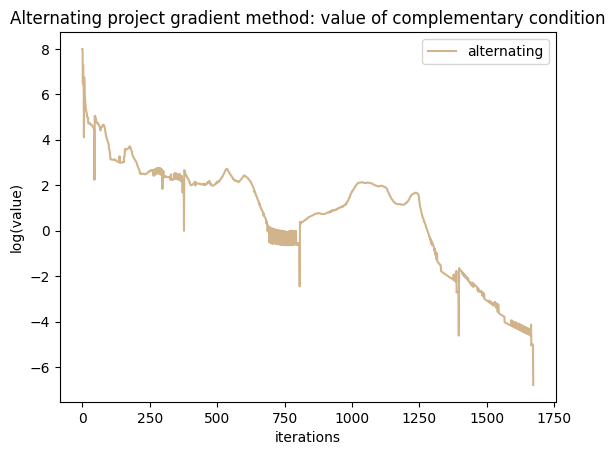

In [ ]:
plot_kkt_alt = np.array(plot_kkt_alt)
plt.plot(range(len(plot_kkt_alt)), np.log(plot_kkt_alt), color='tan', label='alternating')
plt.title("Alternating project gradient method: value of complementary condition")
plt.xlabel("iterations")
plt.ylabel("log(value)")
plt.legend()
plt.show()

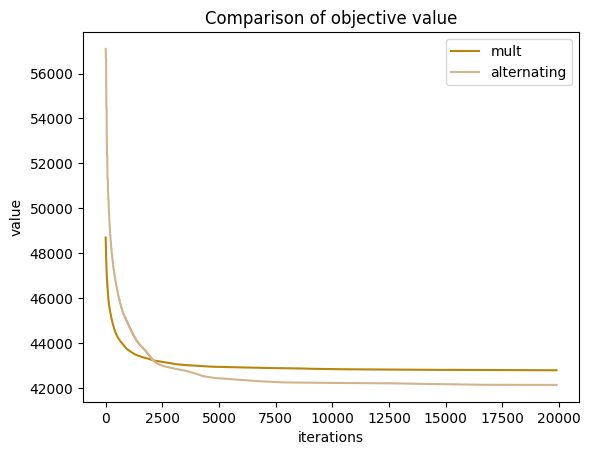

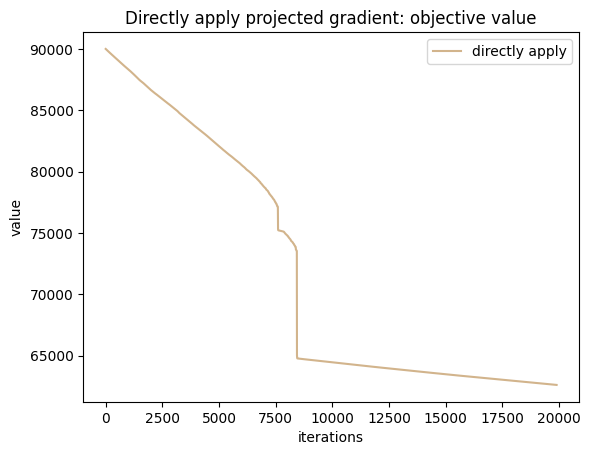

In [ ]:
start = 100
plt.plot(range(len(plot_obj_mul) - start), (plot_obj_mul[start:]), color='darkgoldenrod', label='mult')
plt.plot(range(20000 - start), (plot_obj_alt[start:20000]), color='tan', label='alternating')
plt.title("Comparison of objective value")
plt.xlabel("iterations")
plt.ylabel("value")
plt.legend()
plt.show()

plt.plot(range(len(plot_obj_dir) - start), (plot_obj_dir[start:]), color='tan', label='directly apply')
plt.title("Directly apply projected gradient: objective value")
plt.xlabel("iterations")
plt.ylabel("value")
plt.legend()
plt.show()

## unit test

In [ ]:
# unit test
print(np.linalg.norm(V - W @ H))
W_rand = np.random.uniform(size=(n, r))  # initial value of W
H_rand = np.random.uniform(size=(r, m))  # initial value of H
print(np.linalg.norm(V - W_rand @ H_rand))

290.0814971234515
528.0596917376139


## Alternating KKT condition

In [ ]:
# Alternating KKT condition
print(np.linalg.norm(W * gradient_W(W, H, V)))  # This should be close to 0 if the KKT is satisfied
print(objective_function(V, W, H))
print(W * gradient_W(W, H, V))
print(W, H)

0.0011258743638606784
42073.63748669141
[[ 0.00000000e+00  1.50031026e-04  0.00000000e+00 ... -6.67755576e-05
   0.00000000e+00  0.00000000e+00]
 [-2.16675886e-06  0.00000000e+00  3.53151157e-05 ...  0.00000000e+00
  -4.57785679e-05  0.00000000e+00]
 [-2.74628218e-05  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  4.27223992e-05]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.25402494e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.35769246e-05 ... -5.88687679e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.86710804e-04]]
[[0.         0.24728354 0.         ... 0.32281243 0.         0.        ]
 [0.06150727 0.         0.07601052 ... 0.         0.1083259  0.        ]
 [0.0726588  0.         0.         ... 0.         0.         0.10435675]
 ...
 [0.         0.         0.         ... 0.         0.04563004 0.        ]
 [0.         0.         0.0

# ADMMNMF

In [ ]:
def admmnmf(V, Winit, Hinit, tol, timelimit, maxiter, max_subiter):
    """
    (W, H) = nmf(V, Winit, Hinit, tol, timelimit, maxiter)
    W, H: output solution
    Winit, Hinit: initial solution
    tol: tolerance for a relative stopping condition
    timelimit, maxiter: limit of time and iterations
    """
    total_sub_iter = 0

    W = Winit
    H = Hinit
    initt = time()

    my_projs = []
    his_projs = []
    plot_kkt_alt = []
    plot_obj_alt = np.array([])

    initgrad = np.linalg.norm(np.concatenate((gradient_H(W, H, V).reshape(-1), gradient_W(W, H, V).reshape(-1))))
    print('Init gradient norm %f' % initgrad)
    tolW = max(0.001, tol) * initgrad
    tolH = tolW
    gradW = gradient_W(W, H, V)
    gradH = gradient_H(W, H, V)
    for iter in range(1, maxiter):
        # stopping condition
        my_projnorm = projected_gradient_norm(W, H, V)
        his_projnorm = np.linalg.norm(np.concatenate((gradW[np.logical_or(gradW < 0, W > 0)], gradH[np.logical_or(gradH < 0, H > 0)])))
        projnorm = my_projnorm

        # my_projs.append(my_projnorm)
        # his_projs.append(his_projnorm)

        if projnorm < tol * initgrad or time() - initt > timelimit:
            break

        (W, gradW, iterW, num_sub_iter, sub_obj_values, sub_kkt_values) = nlssubprob(V.T, H.T, W.T, tolW, max_subiter, isadmm=True)
        W = W.T
        gradW = gradW.T
        total_sub_iter += num_sub_iter
        plot_obj_alt = np.concatenate([plot_obj_alt, sub_obj_values])
        plot_kkt_alt = np.concatenate([plot_kkt_alt, sub_kkt_values])

        if iterW == 1:
            tolW = 0.1 * tolW

        (H, gradH, iterH, num_sub_iter, sub_obj_values, sub_kkt_values) = nlssubprob(V, W, H, tolH, max_subiter, isadmm=True)
        total_sub_iter += num_sub_iter
        plot_obj_alt = np.concatenate([plot_obj_alt, sub_obj_values])
        plot_kkt_alt = np.concatenate([plot_kkt_alt, sub_kkt_values])

        if iterH == 1:
            tolH = 0.1 * tolH
        if iter % 10 == 0:
            stdout.write('.')


    print('\nIter = %d Final proj-grad norm %f' % (iter, projnorm))
    # my_projs = np.array(my_projs)
    # his_projs = np.array(his_projs)
    # plt.plot(range(len(my_projs)), np.log(my_projs))
    # plt.plot(range(len(his_projs)), np.log(his_projs))
    # plt.show()
    print("total subiters", total_sub_iter)
    return (W, H, plot_kkt_alt, plot_obj_alt)

In [ ]:
# V = np.copy(worstV)
W = np.copy(W_init)
H = np.copy(H_init)
W, H, plot_kkt_admm, plot_obj_admm = admmnmf(V, W, H, 1e-10, 100000000, 10000, max_subiter=2)

W = np.copy(W_init)
H = np.copy(H_init)
W, H, plot_kkt_alt2, plot_obj_alt2 = admmnmf(V, W, H, 1e-10, 100000000, 10000, max_subiter=1000)

Init gradient norm 86085592.089736
..............................................................................................................................................................................................................................................................................................................................................................................................................
Iter = 3985 Final proj-grad norm 0.008504
total subiters 7968
Init gradient norm 86085592.089736
.......................................................................................................................................................................
Iter = 1674 Final proj-grad norm 0.008493
total subiters 50602


In [ ]:
print(objective_function(V, W, H))

42073.63748669141


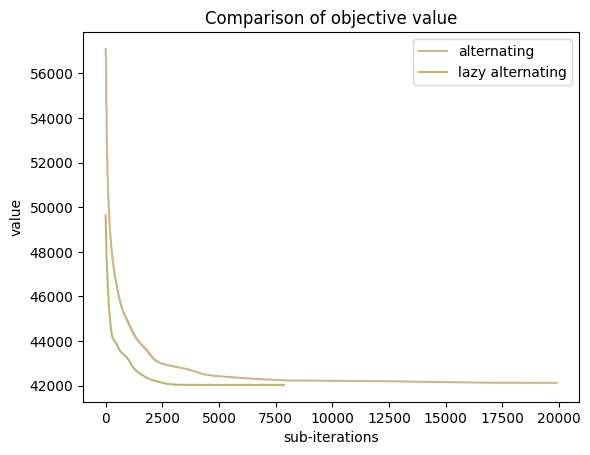

In [ ]:
start = 100
plt.plot(range(20000 - start), (plot_obj_alt2[start:20000]), color='tan', label='alternating')
plt.plot(range(len(plot_obj_admm) - start), (plot_obj_admm[start:]), color='darkkhaki', label='lazy alternating')
plt.title("Comparison of objective value")
plt.xlabel("sub-iterations")
plt.ylabel("value")
plt.legend()
plt.show()

<ipython-input-68-8394d99d9180>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(len(plot_kkt_alt2)), np.log(plot_kkt_alt2), color='tan', label='alternating')
<ipython-input-68-8394d99d9180>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(len(plot_kkt_admm)), np.log(plot_kkt_admm), color='darkkhaki', label='lazy alternating')


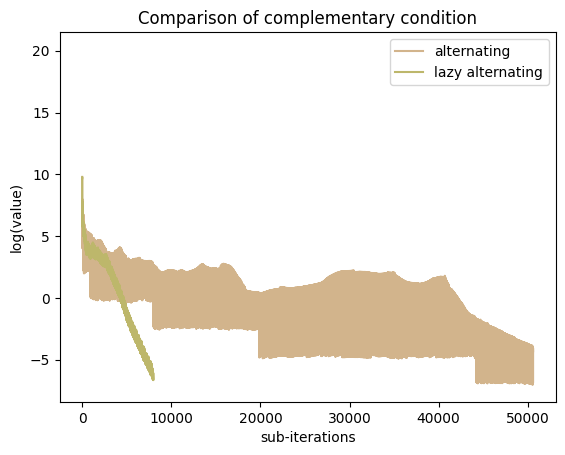

In [ ]:
start = 100
plt.plot(range(len(plot_kkt_alt2)), np.log(plot_kkt_alt2), color='tan', label='alternating')
plt.plot(range(len(plot_kkt_admm)), np.log(plot_kkt_admm), color='darkkhaki', label='lazy alternating')
plt.title("Comparison of complementary condition")
plt.xlabel("sub-iterations")
plt.ylabel("log(value)")
plt.legend()
plt.show()